In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from zipfile import ZipFile
from urllib.request import urlretrieve

from IPython.display import Image
matplotlib.rcParams['figure.figsize'] = (9.0, 9.0) # This makes the images larger in the notebook


In [2]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assests....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)
URL = r"https://www.dropbox.com/s/qa1hsyxt66pvj02/opencv_bootcamp_assets_NB10.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), "opencv_bootcamp_assets_NB10.zip")

# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [26]:
def readImagesAndTimes():
    fileNames = ["img_0.033.jpg","img_0.25.jpg", "img_2.5.jpg", "img_15.jpg"]
    times = np.array([0.033, 0.25, 2.5, 15.0], dtype=np.float32)
    images = []
    for fileName in fileNames:
        img = cv.imread(f"Photos/HDR/{fileName}")
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Convert BGR to RGB
        if img is None:
            raise FileNotFoundError(f"Image {fileName} not found in the specified directory.")
        images.append(img)
    return images, times

In [27]:
images, times = readImagesAndTimes()

alignMTB = cv.createAlignMTB()
alignMTB.process(images, images)
# Parameters:
# - First argument is the list of images to be aligned.
# - Second argument is the list where the aligned images will be stored (in this case, the same list `images`).

# This will align the images based on the MTB algorithm
# MTB stands for Median Threshold Bitmap, which is a method used to align images based on their median intensity values.
# The aligned images will be stored in the same list `images`.

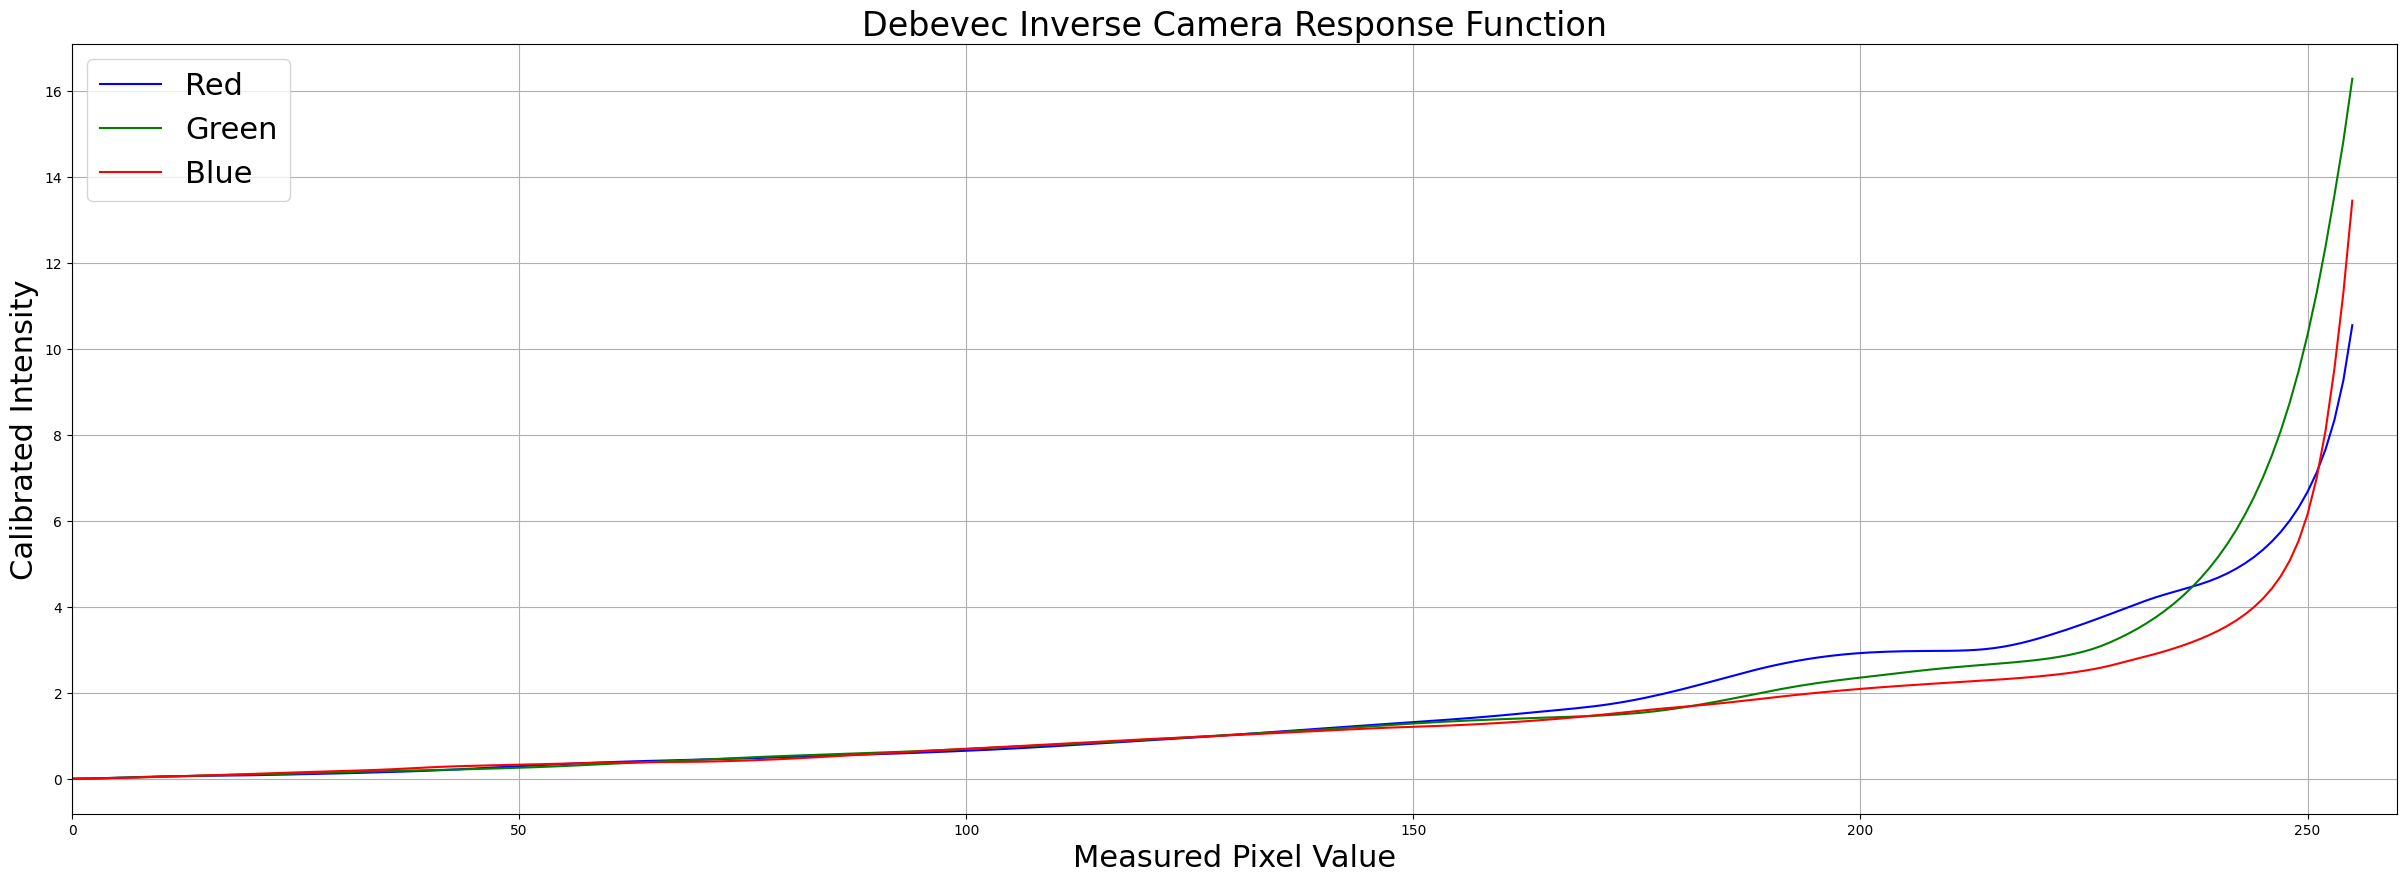

In [ ]:
# Estimate Camera Response Function (CRF)
calibrateDebvec = cv.createCalibrateDebevec()
crf = calibrateDebvec.process(images, times)
# Parameters:
# - First argument is the list of images.
# - Second argument is the list of exposure times corresponding to each image.
# This will estimate the camera response function (CRF) using the Debevec method.
# The CRF is a function that maps pixel values to their corresponding radiance values, which is essential for HDR imaging.
# The estimated CRF will be stored in the variable `crf`.

x = np.arange(256, dtype=np.float32)
y = np.squeeze(crf[:, 0]) # Extract the first channel of the CRF for plotting
# sqieeze() is used to remove any singleton dimensions from the array.

ax = plt.figure(figsize=(30, 10))
plt.title("Debevec Inverse Camera Response Function", fontsize=24)
plt.xlabel("Measured Pixel Value", fontsize=22)
plt.ylabel("Calibrated Intensity", fontsize=22)
plt.xlim([0, 260])
plt.grid()
plt.plot(x, y[:, 0], "b", x, y[:, 1], "g", x, y[:, 2], "r")
plt.legend(["Red", "Green", "Blue"], fontsize=22)
plt.show()

In [29]:
mergedDebvec = cv.createMergeDebevec()
hdrDebvec = mergedDebvec.process(images, times, crf)

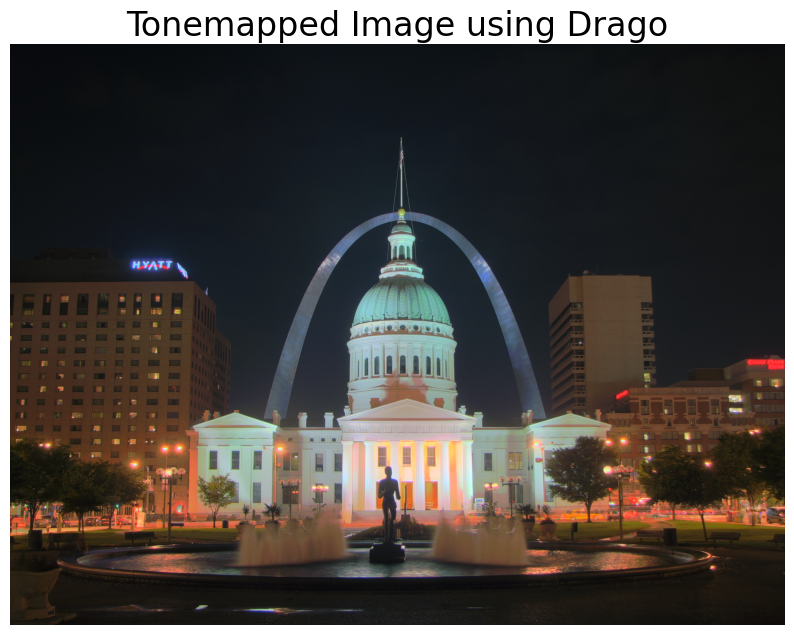

True

In [30]:
# Tonemapping using Drago
# Tonemapping is the process of converting HDR images to LDR (Low Dynamic Range) images for display on standard monitors.
# Drago is one of the tonemapping algorithms that compresses the dynamic range of HDR images while preserving details in both highlights and shadows.
tonemapDrago = cv.createTonemapDrago(1.0, 0.7)
# 1.0 is the gamma value, which controls the overall brightness of the image.
# 0.7 is the saturation value, which controls the color saturation of the image.

ldrDrago = tonemapDrago.process(hdrDebvec)
ldrDrago = 3 * ldrDrago  # Scale the image to enhance brightness

plt.figure(figsize=(10, 10))
plt.title("Tonemapped Image using Drago", fontsize=24)
plt.imshow(np.clip(ldrDrago, 0, 1))
plt.axis("off")
plt.show()
# Save the tonemapped image
cv.imwrite("Photos/HDR/tonemapped_image_drago.jpg", np.clip(ldrDrago * 255, 0, 255).astype(np.uint8))